In [273]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import os
import h5py

In [274]:
path="/content/drive/My Drive/Đồ án/train-scene classification/train.csv"
data = pd.read_csv(path, delimiter=',')
data

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4
...,...,...
17029,24325.jpg,4
17030,24328.jpg,3
17031,24329.jpg,3
17032,24332.jpg,5


In [275]:
print(data.shape)
data.label=data.label.astype(int)

(17034, 2)


In [276]:
data.label=data.label.astype(str)

In [277]:
from keras.preprocessing import  image

In [278]:
file_paths = ['/content/drive/My Drive/Đồ án/train-scene classification/train/{}'.format(file_name) for file_name in data.loc[:,'image_name'].values]

In [279]:
images = []
for file_path in file_paths:
  images.append(cv2.imread(file_path))
  #print(os.path.basename(file_path))

In [280]:
images = [cv2.resize(image,(32,32)) for image in images]

In [281]:
X = np.stack(images)

In [282]:
y = data.loc[:,'label'].values

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=0)

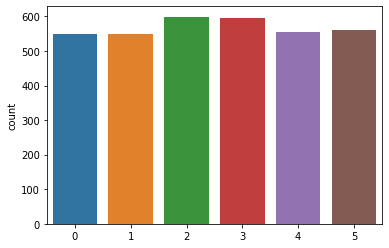

In [284]:
import seaborn as sns
# Count plot for test set
sns.countplot(y_test.ravel())

In [286]:
print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (13627, 32, 32, 3)
y_train shape: (13627,)
13627 train samples
3407 test samples


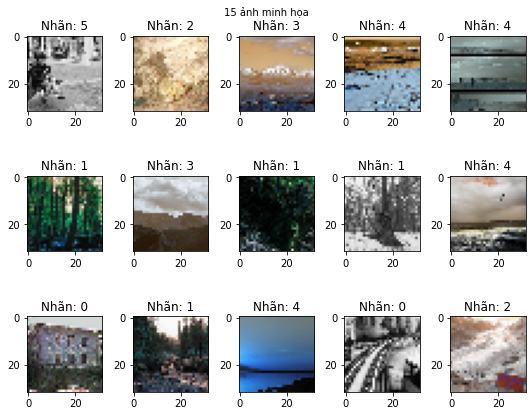

In [287]:
num_row = 3
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
fig.suptitle("15 ảnh minh họa", fontsize=10)
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title('Nhãn: {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

In [288]:
# Convert class vectors to binary class matrices. This is called one hot encoding.
import keras
num_classes = 10  
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [289]:
from keras import layers
from keras import models
from keras import optimizers

In [290]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

# Keras defines a sequential model as a sequential stack of linear layers.
model=Sequential()

# here we using 32 filter layers and kernel size of (3,3), with relu activation function (max(0,x))
# Batch normalization() is a technique for improving the speed, performance, and stability of cnn.
# max pooling reduces the dimensionality of images by reducing the number of pixels in the output from previous cnn
# pool size define size of filter
# Droupout drops out the nodes from the layer and reduce chances of overfitting

#1st layer is input layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(32,32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd layer
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3rd layer
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten convert matrix into single array
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Finally we compile our model with rsmprop optimizer
model.add(Dense(10,activation='softmax'))
model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_57 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_58 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 6, 6, 64)        

In [291]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#One way to avoid overfitting is to terminate the process early using earlystop
earlystop = EarlyStopping(patience = 10)

# Following line will reduce learning rate when a metric has stopped improving. 
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)

callbacks = [earlystop,learning_rate_reduction]

In [292]:

history = model.fit(X_train, y_train,
              batch_size=32,
              epochs=20,
              validation_data=(X_test, y_test),
              callbacks=callbacks
            )

Train on 13627 samples, validate on 3407 samples
Epoch 1/20
13627/13627 [==============================] - 4s 329us/step - loss: 1.4448 - accuracy: 0.5552 - val_loss: 1.1144 - val_accuracy: 0.6249
Epoch 2/20
  704/13627 [>.............................] - ETA: 3s - loss: 1.0581 - accuracy: 0.6420

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


13627/13627 [==============================] - 4s 273us/step - loss: 0.9401 - accuracy: 0.6690 - val_loss: 1.5989 - val_accuracy: 0.5644
Epoch 3/20
13627/13627 [==============================] - 4s 269us/step - loss: 0.8061 - accuracy: 0.7088 - val_loss: 0.7028 - val_accuracy: 0.7455
Epoch 4/20
13627/13627 [==============================] - 4s 266us/step - loss: 0.7436 - accuracy: 0.7323 - val_loss: 0.7608 - val_accuracy: 0.7144
Epoch 5/20
13627/13627 [==============================] - 4s 270us/step - loss: 0.6948 - accuracy: 0.7457 - val_loss: 0.8856 - val_accuracy: 0.7068
Epoch 6/20
13627/13627 [==============================] - 4s 275us/step - loss: 0.6593 - accuracy: 0.7624 - val_loss: 1.3580 - val_accuracy: 0.5788
Epoch 7/20
13627/13627 [==============================] - 4s 275us/step - loss: 0.6458 - accuracy: 0.7700 - val_loss: 0.8398 - val_accuracy: 0.7006
Epoch 8/20
13627/13627 [==============================] - 4s 272us/step - loss: 0.6079 - accuracy: 0.7837 - val_loss: 0.653

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


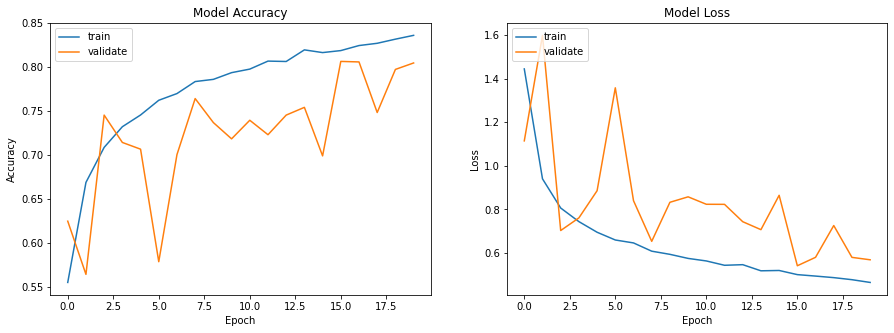

In [293]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

In [294]:
#evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# making prediction
predictions = model.predict(X_test)

3407/3407 [==============================] - 0s 96us/step
Test accuracy: 0.8048136234283447
